In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers

2024-08-04 11:43:47.130710: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-04 11:43:47.133320: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-04 11:43:47.142604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 11:43:47.159316: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 11:43:47.164420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-04 11:43:47.176124: I tensorflow/core/platform/cpu_feature_gu

In [2]:
EMPRESA = 'CMIG3.SA'

In [3]:
def get_data_ticker(ticker, period='5y'):
    data_hist = yf.download(ticker, period=period)
    data_hist = pd.DataFrame(data_hist['Close'])
    data_hist['prev-day-1'] = data_hist['Close'].shift(1)
    data_hist['prev-day-2'] = data_hist['Close'].shift(2)
    data_hist['prev-day-3'] = data_hist['Close'].shift(3)
    data_hist['mm_5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm_21'] = data_hist['Close'].rolling(21).mean()
    data_hist = data_hist.dropna()
    data_hist['tomorrow'] = data_hist['Close'].shift(-1)
    return data_hist

In [4]:
def split_df_X_y(df_model):
    dates = df_model.index
    df_as_np = df_model.to_numpy()
    X = df_as_np[:,:-1]

    X = X.reshape(len(dates), X.shape[1], 1)
    y = df_as_np[:,-1]

    return (dates, X.astype(np.float32), y.astype(np.float32))

df_full = get_data_ticker(EMPRESA, period='max')
df = df_full.dropna()
dates, X, y = split_df_X_y(df)

[*********************100%%**********************]  1 of 1 completed


In [5]:
dates

DatetimeIndex(['2000-01-31', '2000-02-01', '2000-02-02', '2000-02-03',
               '2000-02-04', '2000-02-07', '2000-02-08', '2000-02-09',
               '2000-02-10', '2000-02-11',
               ...
               '2024-07-19', '2024-07-22', '2024-07-23', '2024-07-24',
               '2024-07-25', '2024-07-26', '2024-07-29', '2024-07-30',
               '2024-07-31', '2024-08-01'],
              dtype='datetime64[ns]', name='Date', length=6154, freq=None)

In [6]:
def train_model_lstm(X_train, y_train, X_test, y_test):
    model = Sequential([layers.Input((6,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_feedforward(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(layers.Dense(64, activation='relu', input_dim=6))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_rnn(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(layers.Input((6,1)))
    model.add(layers.SimpleRNN(40, return_sequences=True))
    model.add(layers.SimpleRNN(40))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_cnn(X_train, y_train, X_test, y_test):
    # Create a CNN model
    model = Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6, 1)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

In [7]:
def predict_tomorrow(model):
    last_day = get_data_ticker(EMPRESA, period='1mo') # Buscando um mes de dados pois as vezes quando coloco '1d' vem vazio :(
    date_tomorrow, X_tomorrow, y_tomorrow = split_df_X_y(last_day)
    return model.predict(np.array([X_tomorrow[-1]]))


In [8]:
range_80 = int(len(dates)*.85)
range_90 = int(len(dates)*.95)

dates_train, X_train, y_train = dates[:range_80], X[:range_80], y[:range_80]
dates_test, X_test, y_test = dates[range_80:range_90], X[range_80:range_90], y[range_80:range_90]
dates_validation, X_validation, y_validation = dates[range_90:], X[range_90:], y[range_90:]

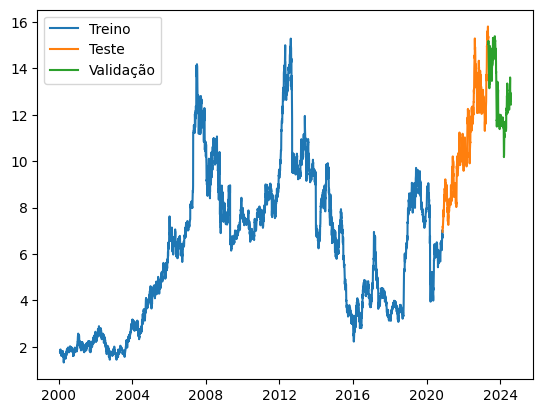

In [9]:
plt.plot(dates_train,y_train, label='Treino')
plt.plot(dates_test,y_test, label='Teste')
plt.plot(dates_validation,y_validation, label='Validação')
plt.legend()

## Treinamento da LSTM

## Resultado com dados nunca vistos pelo modelo

In [10]:
model_lstm = train_model_lstm(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_lstm)

Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 18.8881 - mean_absolute_error: 3.0760 - val_loss: 0.3718 - val_mean_absolute_error: 0.4404
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1040 - mean_absolute_error: 0.2081 - val_loss: 0.2109 - val_mean_absolute_error: 0.3524
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0891 - mean_absolute_error: 0.1979 - val_loss: 0.1885 - val_mean_absolute_error: 0.3250
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0775 - mean_absolute_error: 0.1883 - val_loss: 0.1695 - val_mean_absolute_error: 0.3085
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0800 - mean_absolute_error: 0.1904 - val_loss: 0.1669 - val_mean_absolute_error: 0.3063
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0822 - mean_absolute_error: 0.1852 - val_loss: 0.1579 - val_mean_absolute_error: 0.3005
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0716 - mean_absolute_error: 0.

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


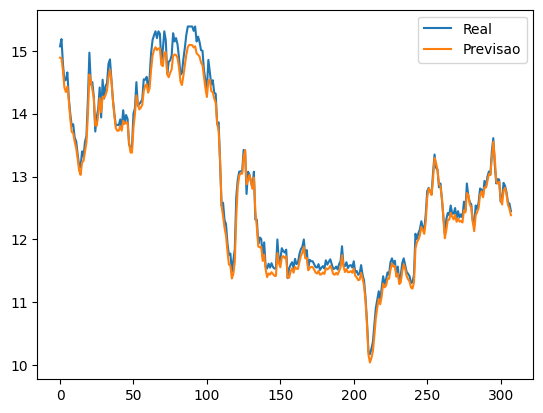

In [11]:
y_pred = model_lstm.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao")
plt.legend()

In [12]:
model_feedforward = train_model_feedforward(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_feedforward)

Epoch 1/100


/home/nikolas/.local/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.2864 - mean_absolute_error: 1.3062 - val_loss: 0.1265 - val_mean_absolute_error: 0.2675
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0566 - mean_absolute_error: 0.1536 - val_loss: 0.1119 - val_mean_absolute_error: 0.2516
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0487 - mean_absolute_error: 0.1400 - val_loss: 0.0935 - val_mean_absolute_error: 0.2266
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0465 - mean_absolute_error: 0.1319 - val_loss: 0.0838 - val_mean_absolute_error: 0.2128
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0411 - mean_absolute_error: 0.1250 - val_loss: 0.0824 - val_mean_absolute_error: 0.2121
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0432 - mean_absolute_error: 0.1253 - val_loss: 0.0740 - val_mean_absolute_error: 0.1985
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0318 - mean_absolute_error: 0.1153 - val_lo

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


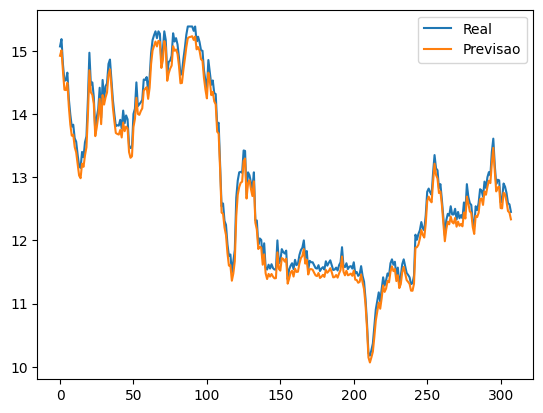

In [13]:
y_pred = model_feedforward.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao")
plt.legend()

In [14]:
model_rnn = train_model_rnn(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_rnn)

Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 13.7961 - mean_absolute_error: 2.4920 - val_loss: 6.0299 - val_mean_absolute_error: 1.8503
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6451 - mean_absolute_error: 0.3788 - val_loss: 2.2214 - val_mean_absolute_error: 1.0090
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2753 - mean_absolute_error: 0.2766 - val_loss: 1.0854 - val_mean_absolute_error: 0.6741
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1932 - mean_absolute_error: 0.2565 - val_loss: 0.5950 - val_mean_absolute_error: 0.5032
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1320 - mean_absolute_error: 0.2288 - val_loss: 0.4205 - val_mean_absolute_error: 0.4397
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1136 - mean_absolute_error: 0.2138 - val_loss: 0.3247 - val_mean_absolute_error: 0.3921
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0993 - mean_absolute_error: 0.

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


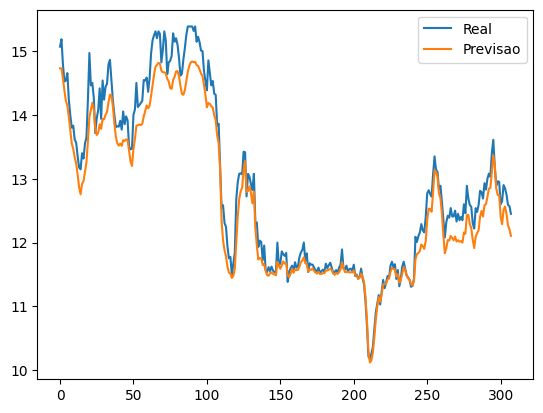

In [15]:
y_pred = model_rnn.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao")
plt.legend()

In [16]:
model_cnn = train_model_cnn(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_cnn)

Epoch 1/100


/home/nikolas/.local/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.8403 - mean_absolute_error: 1.9170 - val_loss: 0.1540 - val_mean_absolute_error: 0.2989
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0703 - mean_absolute_error: 0.1806 - val_loss: 0.1445 - val_mean_absolute_error: 0.2867
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0737 - mean_absolute_error: 0.1733 - val_loss: 0.1361 - val_mean_absolute_error: 0.2725
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0608 - mean_absolute_error: 0.1607 - val_loss: 0.1651 - val_mean_absolute_error: 0.3172
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0612 - mean_absolute_error: 0.1602 - val_loss: 0.1315 - val_mean_absolute_error: 0.2704
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0619 - mean_absolute_error: 0.1618 - val_loss: 0.1269 - val_mean_absolute_error: 0.2641
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0643 - mean_absolute_error: 0.1579 - val_lo

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


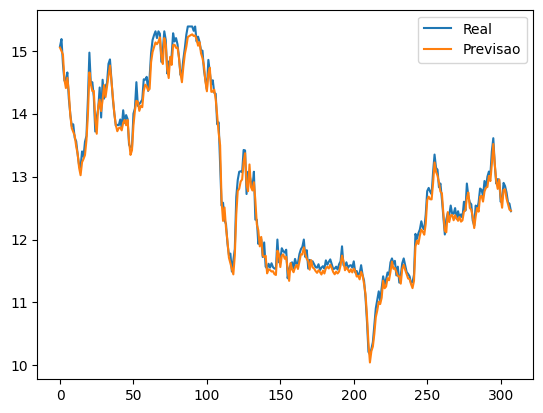

In [17]:
y_pred = model_cnn.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao")
plt.legend()